In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from scipy.signal import savgol_filter    

# The basic RSA model

This is a discrete version of the model proposed by [Lassiter & Goodman, "Adjectival vagueness in a Bayesian model of interpretation", Synthese 194, 2017](https://link.springer.com/article/10.1007/s11229-015-0786-1). It uses a single alternative message, namely a costless tautology.

/tmp/ipykernel_467338/1541074057.py:25: RuntimeWarning: divide by zero encountered in log
  return(np.exp(alpha*np.log(literal_vague(theta,prior))-cost))


<Axes: xlabel='states'>

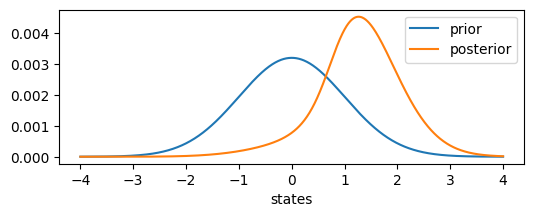

In [43]:
def normalize_vector (vec):
    n = len(vec)
    out = vec if vec.sum(axis=0)==0 else vec/vec.sum(axis=0)
    return out

snorm = stats.norm() # z-distribution
size = 1001
zstates = np.linspace(-4, 4, size)
distribution = snorm.pdf(zstates)
zprior = normalize_vector(distribution)

def literal_vague(theta,prior):
    out = np.zeros(len(prior))
    out[theta:len(prior)]=prior[theta:len(prior)]
    out = normalize_vector(out)
    return out

def literal_silence(prior):
    return(prior)

alpha = 4
cost = 5

def speaker_vague(theta,alpha,cost,prior):
    return(np.exp(alpha*np.log(literal_vague(theta,prior))-cost))
def speaker_silence(theta,alpha,prior):
    return(np.exp(alpha*np.log(literal_silence(prior))))
def speaker_vague_normed(theta,alpha,cost,prior):
    return speaker_vague(theta,alpha,cost,prior)/(speaker_vague(theta,alpha,cost,prior)+speaker_silence(theta,alpha,prior))
def hearer(alpha,cost,prior):
    joint_posterior = np.array(list(map(lambda t: speaker_vague_normed(t,alpha,cost,prior)*prior,range(len(prior)))))
    marginal = joint_posterior.sum(axis=0)
    return normalize_vector(marginal)

hrr = hearer(alpha,cost,zprior)

df = pd.DataFrame({"states":zstates,"prior":zprior,"posterior":hrr})
df.plot(x="states",y=["prior","posterior"],figsize=(6, 2))


# Subsequent updates

This is the setup where a combination of an adverb and an adjectives ("horribly warm") receives an interpretion by first updating with the positive form of the base of the adverb and then subsequently interpreting the positive form of the adjective "warm".

We use a hand-made measure function to stand in for the measure function associated to the adverb.

In [55]:
alpha = 4
costadv = 5
costadj = 5

xnorm = stats.norm(0,3)

def horror_evaluation(x):
    return (x**2)

def predict(measure_function,state_space,state_space_prior,alpha=4,cost_adverb=4,cost_adj=4,rounding=10,smoothing=2):
  measures = np.round(list(map(measure_function,state_space)),rounding)
  # rounding is necessary to avoid spurious unique measures to be found in next line (if the evaluation
  # function is symmetric, we want the same degree to be found twice, not two degrees that differ minimally).
  degs = np.unique(measures)
  eval_prior = normalize_vector(np.array([sum(state_space_prior[np.where(measures==i)[0]]) for i in degs]))
  eval_prior = savgol_filter(eval_prior,window_length=smoothing, polyorder=1) # this is not essential
  evaluation_posterior = hearer(alpha,cost_adverb,eval_prior)
  derived_posterior = np.zeros(len(state_space))
  derived_evaluation_posterior = normalize_vector(np.array([evaluation_posterior[np.where(degs==i)[0][0]] for i in measures]))
  adverb_adjective_posterior = hearer(alpha,cost_adj,derived_evaluation_posterior)
  return measures, degs, eval_prior, evaluation_posterior, derived_evaluation_posterior, adverb_adjective_posterior

msrs, dgrs, evalprior, evalposterior, derived_eval_post,post = predict(horror_evaluation,zstates,zprior,alpha,costadv,costadj,10)

/tmp/ipykernel_467338/1541074057.py:25: RuntimeWarning: divide by zero encountered in log
  return(np.exp(alpha*np.log(literal_vague(theta,prior))-cost))


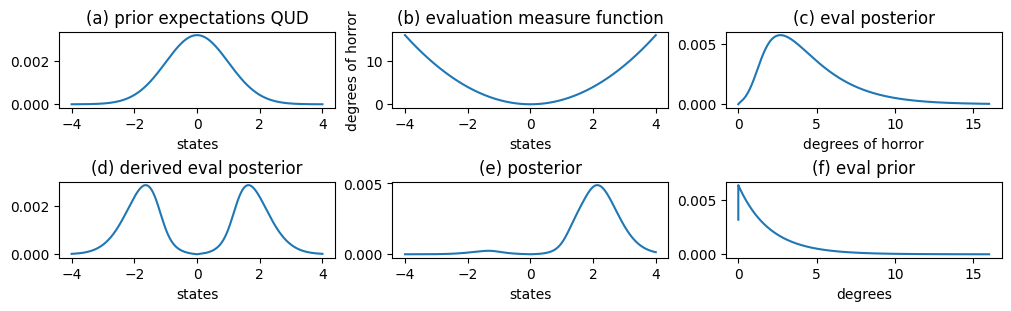

In [56]:
fig, axs = plt.subplots(2, 3, constrained_layout=True)

axs[0,0].plot(zstates,zprior)
axs[0,0].set(xlabel="states",title="(a) prior expectations QUD")
axs[0,1].plot(zstates,msrs)
axs[0,1].set(xlabel="states",ylabel="degrees of horror",title="(b) evaluation measure function")
axs[0,2].plot(dgrs,evalposterior)
axs[0,2].set(xlabel="degrees of horror",title="(c) eval posterior")
axs[1,0].plot(zstates,derived_eval_post)
axs[1,0].set(xlabel="states",title="(d) derived eval posterior")
axs[1,1].plot(zstates,post)
axs[1,1].set(xlabel="states",title="(e) posterior")
axs[1,2].plot(dgrs,evalprior)
axs[1,2].set(xlabel="degrees",title="(f) eval prior")

fig.set_figwidth(10)
fig.set_figheight(3)


## Figures for paper

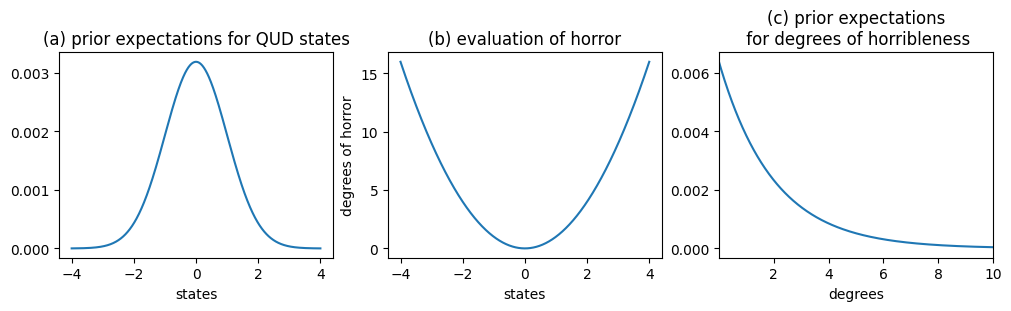

In [57]:
fig, axs = plt.subplots(1, 3, constrained_layout=True)

axs[0].plot(zstates,zprior)
axs[0].set(xlabel="states",title="(a) prior expectations for QUD states")
axs[1].plot(zstates,msrs)
axs[1].set(xlabel="states",ylabel="degrees of horror",title="(b) evaluation of horror")
axs[2].plot(dgrs,evalprior)
axs[2].set(xlabel="degrees",title="(c) prior expectations\n for degrees of horribleness")
axs[2].set_xlim(0.01,10)

fig.set_figwidth(10) 
fig.set_figheight(3) 

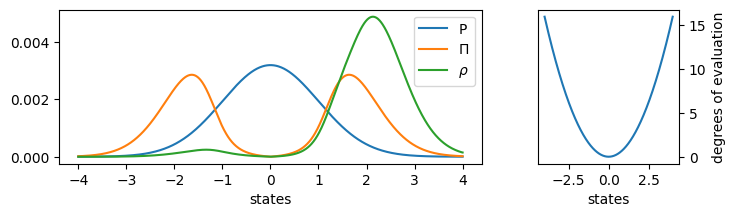

In [59]:
dfhorror = pd.DataFrame({"states":zstates,"prior":zprior,"adverb posterior":derived_eval_post,"adjective posterior":post})
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 2]})

dfhorror.plot(x="states",y=["prior","adverb posterior","adjective posterior"],ax=axs[0])
axs[1].plot(zstates,list(map(horror_evaluation,zstates)))
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[1].set(ylabel="degrees of evaluation",xlabel="states")
axs[0].legend([r"P",r"$\Pi$",r"$\rho$"])
fig.set_figwidth(8) 
fig.set_figheight(2) 

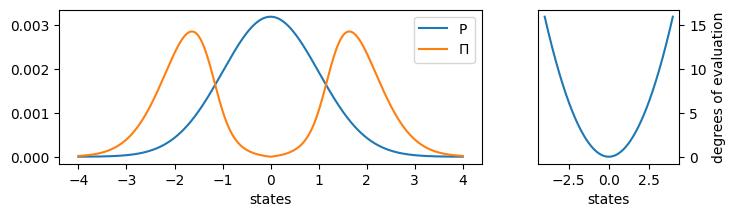

In [60]:
dfhorror = pd.DataFrame({"states":zstates,"prior":zprior,"adverb posterior":derived_eval_post,"adjective posterior":post})
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 2]})

dfhorror.plot(x="states",y=["prior","adverb posterior"],ax=axs[0])
axs[1].plot(zstates,list(map(horror_evaluation,zstates)))
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[1].set(ylabel="degrees of evaluation",xlabel="states")
axs[0].legend([r"P",r"$\Pi$",r"$\rho$"])
fig.set_figwidth(8) 
fig.set_figheight(2)

## Subsequent update with positive evaluation 

/tmp/ipykernel_467338/1541074057.py:25: RuntimeWarning: divide by zero encountered in log
  return(np.exp(alpha*np.log(literal_vague(theta,prior))-cost))


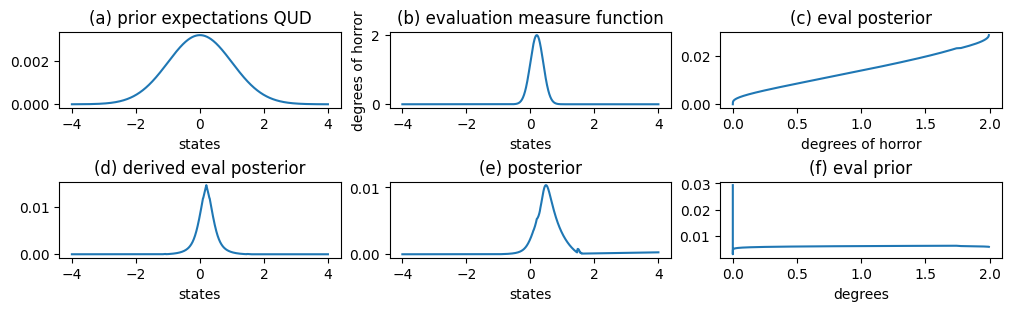

In [45]:
xnorm = stats.norm(0.2,.2)

def pleasant_evaluation(x):
    return xnorm.pdf(x)

msrs, dgrs, evalprior, evalposterior, derived_eval_post,post = predict(pleasant_evaluation,zstates,zprior,alpha,costadv,costadj,10,25)

fig, axs = plt.subplots(2, 3, constrained_layout=True)

axs[0,0].plot(zstates,zprior)
axs[0,0].set(xlabel="states",title="(a) prior expectations QUD")
axs[0,1].plot(zstates,msrs)
axs[0,1].set(xlabel="states",ylabel="degrees of horror",title="(b) evaluation measure function")
axs[0,2].plot(dgrs,evalposterior)
axs[0,2].set(xlabel="degrees of horror",title="(c) eval posterior")
axs[1,0].plot(zstates,derived_eval_post)
axs[1,0].set(xlabel="states",title="(d) derived eval posterior")
axs[1,1].plot(zstates,post)
axs[1,1].set(xlabel="states",title="(e) posterior")
axs[1,2].plot(dgrs,evalprior)
axs[1,2].set(xlabel="degrees",title="(f) eval prior")

fig.set_figwidth(10)
fig.set_figheight(3)


## Figures for paper

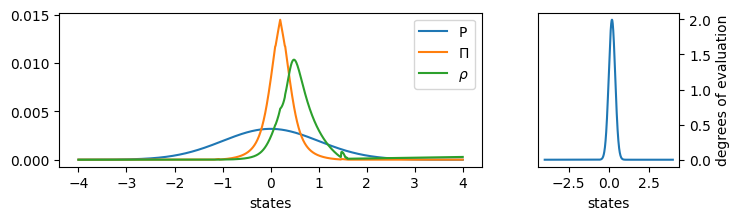

In [54]:
dfpleasant = pd.DataFrame({"states":zstates,"prior":zprior,"adverb posterior":derived_eval_post,"adjective posterior":post})
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 2]})

dfpleasant.plot(x="states",y=["prior","adverb posterior","adjective posterior"],ax=axs[0])
axs[1].plot(zstates,list(map(pleasant_evaluation,zstates)))
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[1].set(ylabel="degrees of evaluation",xlabel="states")
axs[0].legend([r"P",r"$\Pi$",r"$\rho$"])
fig.set_figwidth(8) 
fig.set_figheight(2) 

# The conjunctive approach




In [38]:
def horror_evaluation(x):
    return (x)**2

snorm = stats.norm() # z-distribution
size = 501
zstates = np.linspace(-4, 4, size)
distribution = snorm.pdf(zstates)
zprior = normalize_vector(distribution)

measures = np.array(list(map(horror_evaluation,zstates)))
degrees = np.linspace(measures.min(),measures.max(),1000)

def literal_vague(theta_adv,theta_adj,meas,prior,state_space):
    lv = prior.copy()
    lv[np.where(meas<theta_adv)[0]] = 0
    lv[np.where(state_space<theta_adj)[0]] = 0
    return normalize_vector(lv)

def nplog(vec):
    vec[np.where(vec==0)] = 1e-50
    return np.log(vec)
    
def literal_silence(prior):
    return(prior)
def speaker_vague(theta_adv,theta_adj,meas,alpha,cost,prior,state_space):
    return(np.exp(alpha*nplog(literal_vague(theta_adv,theta_adj,meas,prior,state_space))-cost))
def speaker_silence(alpha,prior):
    return np.exp(alpha*nplog(literal_silence(prior)))
def speaker_vague_normed(theta_adv,theta_adj,meas,alpha,cost,prior,state_space):
    return speaker_vague(theta_adv,theta_adj,meas,alpha,cost,prior,state_space)/(speaker_vague(theta_adv,theta_adj,meas,alpha,cost,prior,state_space)+speaker_silence(alpha,prior))
def hearer(meas,degree_space,state_space,alpha,cost,prior):
    joint_posterior = np.array(list(map(lambda t: speaker_vague_normed(t[0],t[1],meas,alpha,cost,prior,state_space)*prior,[(i,j) for i in degree_space for j in state_space])))
    marginal = joint_posterior.sum(axis=0)
    return normalize_vector(marginal)

hrr = hearer(measures,degrees,zstates,4,6,zprior)


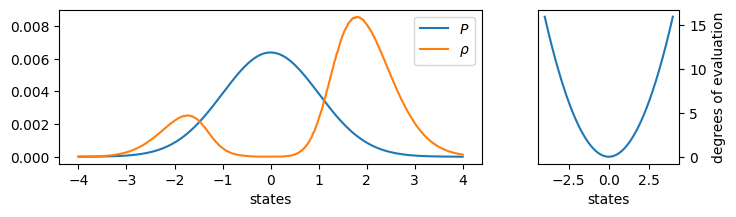

In [40]:
dfconjunctive = pd.DataFrame({"states":zstates,"prior":zprior,"posterior":hrr})
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 2]})

dfconjunctive.plot(x="states",y=["prior","posterior"],ax=axs[0])
axs[0].legend([r'$P$',r'$\rho$'])
axs[1].plot(zstates,measures)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[1].set(ylabel="degrees of evaluation",xlabel="states")

fig.set_figwidth(8) 
fig.set_figheight(2) 
